#### VGG16모델

In [ ]:
from tensorflow.keras.applications import VGG16, ResNet50, ResNet50V2, Xception

model = VGG16(input_shape=(32, 32, 3), include_top=False, weights='imagenet')
model.summary()

In [ ]:
print('model:',  model)
print('model output: ',  model.output) # 맨 마지막 layer가 출력된다.

#### Pretained 모델 기반으로 CIFAR 10 분류 모델 재 생성

In [ ]:
IMAGE_SIZE = 32
BATCH_SIZE = 64

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

clear_session()

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
bm_output =  base_model.output

x = GlobalAveragePooling2D()(bm_output)
x = Dense(50, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model = Model(input_tensor, output)
model.summary()

In [ ]:
#block5_pool (MaxPooling2D)  : (None, 1, 1, 512) 이므로 1x1라서 성능이 떨어진다.  

#### 데이터 전처리

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

import random as python_random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

def set_random_seed(seed_value):
    np.random.seed(seed_value)
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)

# 0~1사이의 값으로 변경
def get_preprocessed_data(images, labels, scaling=True):
    if scaling:
        images = np.array(images/255.0, dtype=np.float32)
    else:
        images = np.array(images, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    return images, labels

# 0~1사이의 값을 받고, OHE적용
def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels, scaling=False)
    oh_labels = to_categorical(labels)
    return images, oh_labels

# 학습/검증/테스트 데이터 세트에 전처리 및 OHE로 적용후 반환
def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2023):
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
    
    # 학습데이터를 학습데이터와 검증데이터로 분리
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_labels, test_size=valid_size, random_state=random_state)
    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels)



In [ ]:
set_random_seed(2023)

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

In [ ]:
(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
    get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2023)
print(tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)

#### ImageDataGenerator로 Augmentation설정

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    horizontal_flip=True,
    rescale=1/255.0
)

valid_generator = ImageDataGenerator(rescale=1/255.0)

flow_tr_gen = train_generator.flow(tr_images, tr_oh_labels, batch_size=BATCH_SIZE, shuffle=True)
flow_val_gen = valid_generator.flow(val_images, val_oh_labels, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
image_batch, label_batch = next(flow_tr_gen)
print(image_batch.shape, label_batch.shape)

### 전체 모델 생성

In [27]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import numpy as np
import pandas as pd
import cv2

import random as python_random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception

# seed 를 설정해서 학습시마다 동일한 결과 유도. 불행히도 의도한 대로 동작하지 않음. 
def set_random_seed(seed_value):
    np.random.seed(seed_value)
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)

# 0 ~ 1사이값의 float32로 변경하는 함수
def get_preprocessed_data(images, labels, scaling=True):
    
    # 학습과 테스트 이미지 array를 0~1 사이값으로 scale 및 float32 형 변형. 
    if scaling:
        images = np.array(images/255.0, dtype=np.float32)
    else:
        images = np.array(images, dtype=np.float32)
        
    labels = np.array(labels, dtype=np.float32)
    
    return images, labels

# 0 ~ 1사이값 float32로 변경하는 함수 호출 한 뒤 OHE 적용 
def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels, scaling=False)
    # OHE 적용 
    oh_labels = to_categorical(labels)
    return images, oh_labels

# 학습/검증/테스트 데이터 세트에 전처리 및 OHE 적용한 뒤 반환 
def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021):
    # 학습 및 테스트 데이터 세트를  0 ~ 1사이값 float32로 변경 및 OHE 적용. 
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
    
    # 학습 데이터를 검증 데이터 세트로 다시 분리
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    
    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels ) 

# 입력 image의 크기를 resize 값 만큼 증가. CIFAR10의 이미지가 32x32로 작아서 마지막 feature map의 크기가 1로 되어 모델 성능이 좋지 않음. 
# 마지막 feature map의 크기를 2로 만들기 위해 resize를 64로 하여 입력 이미지 크기를 변경. 단 메모리를 크게 소비하므로 64이상은 kernel이 다운됨. 
def get_resized_images(images, resize=64):
    image_cnt = images.shape[0] # 50k, 32, 32, 3
    resized_images = np.zeros((images.shape[0], resize, resize, 3)) # 50k, 64, 64, 4
    for i in range(image_cnt):
        resized_image = cv2.resize(images[i], (resize, resize))
        resized_images[i] = resized_image # 50k, 64, 64, 3
    
    return resized_images

def create_model(model_name='vgg16', verbose=False):
    
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50':
        base_model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception':
        base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    
    bm_output = base_model.output

    x = GlobalAveragePooling2D()(bm_output)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu', name='fc1')(x)
    output = Dense(10, activation='softmax', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)
    model.summary()
        
    return model

In [28]:
IMAGE_SIZE = 32
BATCH_SIZE = 64

def do_cifar10_train_evaluation(image_size=IMAGE_SIZE, model_name='vgg16'):
    set_random_seed(2021)
    # CIFAR10 데이터 재 로딩 및 Scaling/OHE 전처리 적용하여 학습/검증/데이터 세트 생성. 
    (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
    (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
        get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021)
    print('데이터 세트 shape:', tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)
    
    # 만약 image_size가 32보다 크면 이미지 크기 재조정. 
    if image_size > 32:
        tr_images = get_resized_images(tr_images)
        val_images = get_resized_images(val_images)
        test_images = get_resized_images(test_images)
    
    # 학습/검증/테스트용 ImageDataGenerator와 flow로 pipeline 생성. 
    train_generator = ImageDataGenerator(
        horizontal_flip=True,
        rescale=1/255.0
    )
    valid_generator = ImageDataGenerator(rescale=1/255.0)
    test_generator = ImageDataGenerator(rescale=1/255.0)

    flow_tr_gen = train_generator.flow(tr_images, tr_oh_labels, batch_size=BATCH_SIZE, shuffle=True)
    flow_val_gen = valid_generator.flow(val_images, val_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
    flow_test_gen = train_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
    
    # model_name 에 따른 모델 생성하고 모델 학습 및 검증 수행. 
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
    rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
    # 10번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
    ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
    
    tr_data_len = tr_images.shape[0]
    val_data_len = val_images.shape[0]
    history = model.fit(flow_tr_gen, epochs=40, 
                        steps_per_epoch=int(np.ceil(tr_data_len/BATCH_SIZE)), 
                        validation_data=flow_val_gen, validation_steps=int(np.ceil(val_data_len/BATCH_SIZE)),
                        callbacks=[rlr_cb, ely_cb])
    # 테스트 데이터 세트로 모델 성능 검증 
    evaluation_result = model.evaluate(flow_test_gen)
    print('테스트 데이터 세트 evaluation 결과:', evaluation_result)
    return history, evaluation_result

In [29]:
import gc

gc.collect()

42

In [30]:
history, evaluation_result = do_cifar10_train_evaluation(image_size=64, model_name='xception')

데이터 세트 shape: (42500, 32, 32, 3) (42500, 10) (7500, 32, 32, 3) (7500, 10) (10000, 32, 32, 3) (10000, 10)
83689472/83683744 [==============================] - 40s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 15, 15, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 15, 15, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Ac

c:\Users\minsu\anaconda3\envs\hongkyu\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


665/665 [==============================] - 55s 74ms/step - loss: 0.7886 - accuracy: 0.7417 - val_loss: 0.4805 - val_accuracy: 0.8487
Epoch 2/40
665/665 [==============================] - 48s 72ms/step - loss: 0.4061 - accuracy: 0.8690 - val_loss: 0.5174 - val_accuracy: 0.8357
Epoch 3/40
665/665 [==============================] - 48s 72ms/step - loss: 0.3117 - accuracy: 0.9000 - val_loss: 0.4965 - val_accuracy: 0.8521
Epoch 4/40
665/665 [==============================] - 48s 72ms/step - loss: 0.2568 - accuracy: 0.9167 - val_loss: 0.5943 - val_accuracy: 0.8240
Epoch 5/40
665/665 [==============================] - 48s 72ms/step - loss: 0.2246 - accuracy: 0.9269 - val_loss: 0.3225 - val_accuracy: 0.8929
Epoch 6/40
665/665 [==============================] - 48s 72ms/step - loss: 0.1767 - accuracy: 0.9422 - val_loss: 0.3081 - val_accuracy: 0.9055
Epoch 7/40
665/665 [==============================] - 48s 73ms/step - loss: 0.1507 - accuracy: 0.9506 - val_loss: 0.3737 - val_accuracy: 0.8832
Epo

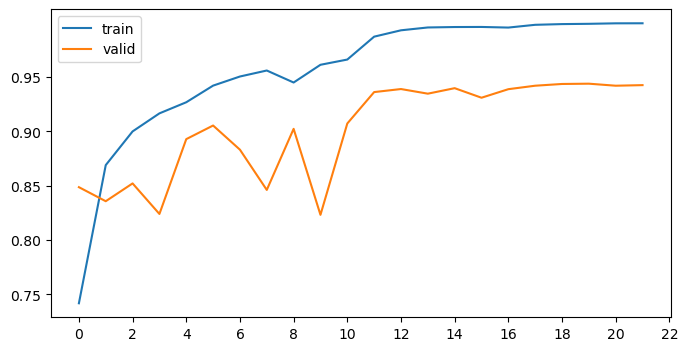

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(8, 4))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xticks(np.arange(0, 30, 2))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    
show_history(history)